In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Load the 7-day weather forecast exported from the API
df_weather = pd.read_csv("../../Extract/meteo/weather_7_day_forecast.csv")

In [3]:
# Standardize the city column name for downstream joins
df_weather = df_weather.rename(columns={"city": "city_name"})

In [4]:
# Quick null check across all columns
null_values = df_weather.isnull().sum()
print("Number of missing values per column:")
print(null_values)

Number of missing values per column:
city_name          0
date               0
temp_min           0
temp_max           0
temp_feels_like    0
humidity           0
pressure           0
wind_speed         0
wind_gust          0
wind_deg           0
clouds             0
uvi                0
dew_point          0
pop                0
sunrise            0
sunset             0
moon_phase         0
conditions         0
dtype: int64


In [5]:
df_weather.head()

,city_name,date,temp_min,temp_max,temp_feels_like,humidity,pressure,wind_speed,wind_gust,wind_deg,clouds,uvi,dew_point,pop,sunrise,sunset,moon_phase,conditions
0,"Le Mont-Saint-Michel, France",2025-04-24,8.52,14.66,13.88,65,1021,4.76,9.24,271,84,5.66,7.95,0.0,04:58:13,19:09:46,0.87,broken clouds
1,"Le Mont-Saint-Michel, France",2025-04-25,8.32,16.44,15.15,60,1020,3.77,6.24,109,100,5.81,7.84,0.0,04:56:24,19:11:15,0.91,overcast clouds
2,"Le Mont-Saint-Michel, France",2025-04-26,9.75,14.61,12.12,91,1022,4.33,6.24,321,100,4.41,10.81,1.0,04:54:37,19:12:44,0.94,moderate rain
3,"Le Mont-Saint-Michel, France",2025-04-27,7.69,16.41,15.53,69,1025,5.64,7.59,320,49,5.72,10.16,0.0,04:52:51,19:14:12,0.00,scattered clouds
4,"Le Mont-Saint-Michel, France",2025-04-28,8.55,19.13,18.18,59,1024,4.39,8.92,74,82,5.67,10.46,0.0,04:51:06,19:15:41,0.02,broken clouds


In [6]:
# Inspect which cities are present in the weather file (deduplicated and sorted)
unique_cities_weather = df_weather['city_name'].unique()
unique_cities_weather = sorted(unique_cities_weather)
for city in unique_cities_weather:
    print(city)

Aigues-Mortes, France
Aix-en-Provence, France
Amiens, France
Annecy, France
Ariège, France
Avignon, France
Bayeux, France
Bayonne, France
Besançon, France
Biarritz, France
Bormes-les-Mimosas, France
Carcassonne, France
Cassis, France
Château du Haut-Koenigsbourg, France
Collioure, France
Colmar, France
Dijon, France
Eguisheim, France
Gorges du Verdon, France
Grenoble, France
La Rochelle, France
Le Havre, France
Le Mont-Saint-Michel, France
Lille, France
Lyon, France
Marseille, France
Montauban, France
Nimes, France
Paris, France
Rouen, France
Saint-Malo, France
Sainte-Marie de la Mer, France
Strasbourg, France
Toulouse, France
Uzes, France


In [7]:
# Normalize city names (remove trailing ", France" if present) and strip spaces
df_weather['city_name'] = (
    df_weather['city_name']
    .str.replace(', France', '', regex=False)
    .str.strip()
)

# Sanity check after normalization
print("Weather city names corrected:")
print(sorted(df_weather['city_name'].unique()))


Weather city names corrected:
['Aigues-Mortes', 'Aix-en-Provence', 'Amiens', 'Annecy', 'Ariège', 'Avignon', 'Bayeux', 'Bayonne', 'Besançon', 'Biarritz', 'Bormes-les-Mimosas', 'Carcassonne', 'Cassis', 'Château du Haut-Koenigsbourg', 'Collioure', 'Colmar', 'Dijon', 'Eguisheim', 'Gorges du Verdon', 'Grenoble', 'La Rochelle', 'Le Havre', 'Le Mont-Saint-Michel', 'Lille', 'Lyon', 'Marseille', 'Montauban', 'Nimes', 'Paris', 'Rouen', 'Saint-Malo', 'Sainte-Marie de la Mer', 'Strasbourg', 'Toulouse', 'Uzes']


In [8]:
# Bring hotel reference IDs to map a stable city_id onto the weather data
df_hotels = pd.read_csv("../../Transform/hotels/data/hotels.csv")

In [9]:
# Build a mapping {city_name -> city_id} from the hotels dataset (unique pairs)
city_id_mapping = dict(
    df_hotels[['city_name', 'city_id']].drop_duplicates().values
)

In [10]:
# Enrich weather with the canonical city_id
df_weather['city_id'] = df_weather['city_name'].map(city_id_mapping)


In [11]:
# Validate that every weather row now has a city_id
missing_city_id = df_weather[df_weather['city_id'].isnull()]

if missing_city_id.empty:
    print("All cities in weather have a valid city_id!")
else:
    print("Some cities are missing a city_id:")
    display(missing_city_id)


All cities in weather have a valid city_id!


In [12]:
# Cross-check city_id consistency between hotels and weather
# - Reduce to unique pairs in each dataset
df_check_hotels = df_hotels[['city_id', 'city_name']].drop_duplicates()
df_check_weather = df_weather[['city_id', 'city_name']].drop_duplicates()

# Outer join on city_name to catch any mismatches
df_check = pd.merge(
    df_check_hotels,
    df_check_weather,
    left_on='city_name',
    right_on='city_name',
    how='outer',  
    indicator=True
)

print("Verification of city_id between hotels and weather:")
display(df_check)

# Flag rows where the two city_id columns differ
mismatches = df_check[df_check['city_id_x'] != df_check['city_id_y']]

if mismatches.empty:
    print("All city_ids match correctly between hotels and weather!")
else:
    print("Mismatched city_ids found:")
    display(mismatches[['city_name', 'city_id_x', 'city_name', 'city_id_y']])


Verification of city_id between hotels and weather:


,city_id_x,city_name,city_id_y,_merge
0,1,Aigues-Mortes,1,both
1,2,Aix-en-Provence,2,both
2,3,Amiens,3,both
3,4,Annecy,4,both
4,5,Ariège,5,both
5,6,Avignon,6,both
6,7,Bayeux,7,both
7,8,Bayonne,8,both
8,9,Besançon,9,both
9,10,Biarritz,10,both


All city_ids match correctly between hotels and weather!


In [13]:
# Inspect available columns before feature selection
print("Columns in df_weather:")
print(df_weather.columns.tolist())

Columns in df_weather:
['city_name', 'date', 'temp_min', 'temp_max', 'temp_feels_like', 'humidity', 'pressure', 'wind_speed', 'wind_gust', 'wind_deg', 'clouds', 'uvi', 'dew_point', 'pop', 'sunrise', 'sunset', 'moon_phase', 'conditions', 'city_id']


In [14]:
# Drop fields not needed for the next step 
columns_to_drop = [
    'date', 'pressure', 'wind_gust', 'wind_deg', 'uvi',
    'dew_point', 'sunrise', 'sunset', 'moon_phase'
]

# Drop unnecessary columns
df_weather = df_weather.drop(columns=columns_to_drop)

print("Columns dropped successfully. Current columns:")
print(df_weather.columns.tolist())


Columns dropped successfully. Current columns:
['city_name', 'temp_min', 'temp_max', 'temp_feels_like', 'humidity', 'wind_speed', 'clouds', 'pop', 'conditions', 'city_id']


In [15]:
# Basic sanity ranges for key variables (helps catch unit or parsing issues)
print("Checking for abnormal values:\n")

# Temperature checks
print(f"temp_min: min = {df_weather['temp_min'].min()}, max = {df_weather['temp_min'].max()}")
print(f"temp_max: min = {df_weather['temp_max'].min()}, max = {df_weather['temp_max'].max()}")
print(f"temp_feels_like: min = {df_weather['temp_feels_like'].min()}, max = {df_weather['temp_feels_like'].max()}")

# Humidity checks
print(f"humidity: min = {df_weather['humidity'].min()}, max = {df_weather['humidity'].max()}")

# Wind speed checks
print(f"wind_speed: min = {df_weather['wind_speed'].min()}, max = {df_weather['wind_speed'].max()}")

# Clouds checks
print(f"clouds: min = {df_weather['clouds'].min()}, max = {df_weather['clouds'].max()}")

# POP (Probability of Precipitation) checks
print(f"pop: min = {df_weather['pop'].min()}, max = {df_weather['pop'].max()}")


Checking for abnormal values:

temp_min: min = 3.88, max = 16.84
temp_max: min = 8.51, max = 25.85
temp_feels_like: min = 6.38, max = 25.57
humidity: min = 32, max = 98
wind_speed: min = 1.7, max = 13.99
clouds: min = 0, max = 100
pop: min = 0.0, max = 1.0


In [16]:
# Correlation between core numeric weather variables (daily granularity)
numeric_cols = [
    'temp_min', 'temp_max', 'temp_feels_like', 
    'humidity', 'wind_speed', 'clouds', 'pop'
]

correlation_matrix = df_weather[numeric_cols].corr()
display(correlation_matrix)


,temp_min,temp_max,temp_feels_like,humidity,wind_speed,clouds,pop
temp_min,1.000000,0.520028,0.551408,-0.245044,0.253614,-0.315709,-0.091545
temp_max,0.520028,1.000000,0.956696,-0.789809,0.134297,-0.701252,-0.465888
temp_feels_like,0.551408,0.956696,1.000000,-0.774566,0.082056,-0.724753,-0.476319
humidity,-0.245044,-0.789809,-0.774566,1.000000,-0.069117,0.684537,0.561976
wind_speed,0.253614,0.134297,0.082056,-0.069117,1.000000,-0.179689,-0.047180
clouds,-0.315709,-0.701252,-0.724753,0.684537,-0.179689,1.000000,0.503200
pop,-0.091545,-0.465888,-0.476319,0.561976,-0.047180,0.503200,1.000000


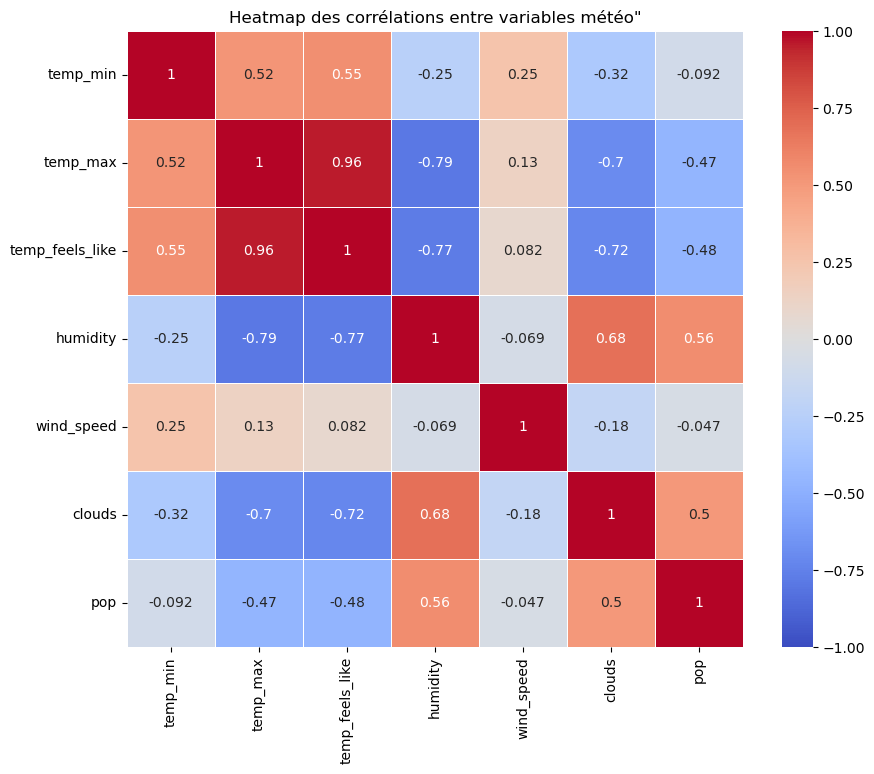

In [ ]:
# Plot heatmap to visualize relationships between weather variables
correlation_matrix = df_weather[numeric_cols].corr()

# Create a heatmap for a more visual interpretation
plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix, 
    annot=True,       # Display correlation values inside the cells
    cmap='coolwarm',  
    vmin=-1, vmax=1,  # Fix color scale for consistency across plots
    square=True,      # Make cells square for better readability
    linewidths=0.5    # Thin lines between cells
)

plt.title('Heatmap des corrélations entre variables météo"')
plt.show()


In [18]:
# Drop 'temp_feels_like' since it is highly correlated with temp_max
column_to_drop = [
    'temp_feels_like'
]
df_weather = df_weather.drop(columns=column_to_drop)

print("Column dropped successfully. Current columns:")
print(df_weather.columns.tolist())

Column dropped successfully. Current columns:
['city_name', 'temp_min', 'temp_max', 'humidity', 'wind_speed', 'clouds', 'pop', 'conditions', 'city_id']


In [19]:
# List of variables to aggregate
columns_to_aggregate = [
    'temp_max',
    'humidity',
    'pop',
    'wind_speed',  
    'clouds'       
]

# Group by city_id and city_name
# Use mean for most variables, but sum for 'pop' (total precipitation probability)
df_weather_grouped = df_weather.groupby(['city_id', 'city_name']).agg({
    'temp_max': 'mean',
    'humidity': 'mean',
    'pop': 'sum', # total rain probability over 7 days
    'wind_speed': 'mean',
    'clouds': 'mean'
}).reset_index()

print("Weather data aggregated by city:")
display(df_weather_grouped.head())


Weather data aggregated by city:


,city_id,city_name,temp_max,humidity,pop,wind_speed,clouds
0,1,Aigues-Mortes,19.544286,53.714286,1.00,5.901429,29.571429
1,2,Aix-en-Provence,21.091429,42.857143,1.83,5.071429,30.571429
2,3,Amiens,18.577143,60.571429,1.00,4.708571,56.285714
3,4,Annecy,18.451429,59.000000,2.10,2.664286,41.714286
4,5,Ariège,15.375714,61.000000,3.20,2.881429,44.571429


In [20]:
# Create a custom score to evaluate 'good weather'
df_weather_grouped['good_weather_score'] = (
    df_weather_grouped['temp_max'] * 2           # bonus for higher temperature
    - df_weather_grouped['humidity'] * 0.5        # penalty for humidity
    - df_weather_grouped['pop'] * 50             # strong penalty for rain probability
    - df_weather_grouped['wind_speed'] * 1       # penalty for wind
    - df_weather_grouped['clouds'] * 0.2          # penalty for clouds
)

# Sort by best weather score
df_top5_weather = df_weather_grouped.sort_values(by='good_weather_score', ascending=False).head(5)

# Display the top 5 cities with the best expected weather
print("Top 5 cities with the best expected weather:")
display(df_top5_weather[['city_name', 'good_weather_score', 'temp_max', 'humidity', 'pop']])


Top 5 cities with the best expected weather:


,city_name,good_weather_score,temp_max,humidity,pop
23,Lille,-2.472857,19.190000,51.000000,0.00
28,Paris,-7.521429,20.245714,46.285714,0.23
10,Bormes-les-Mimosas,-24.988571,18.968571,54.714286,0.46
6,Bayeux,-28.694286,16.518571,67.857143,0.20
21,Le Havre,-39.445714,15.952857,67.285714,0.45


In [21]:
# Recalculate with better balanced weights
df_weather_grouped['good_weather_score'] = (
    df_weather_grouped['temp_max'] * 3           # Stronger weight for warm temperatures
    - df_weather_grouped['humidity'] * 0.3       # Lighter humidity penalty
    - df_weather_grouped['pop'] * 30             # Lighter rain penalty
    - df_weather_grouped['wind_speed'] * 0.5     # Light penalty for wind speed
    - df_weather_grouped['clouds'] * 0.1          # Very light penalty for clouds
)

# Sort by good_weather_score descending
df_top5_weather = df_weather_grouped.sort_values(by='good_weather_score', ascending=False).head(5)

print("Top 5 cities with the best expected weather (new balanced score):")
display(df_top5_weather[['city_name', 'good_weather_score', 'temp_max', 'humidity', 'pop']])



Top 5 cities with the best expected weather (new balanced score):


,city_name,good_weather_score,temp_max,humidity,pop
23,Lille,34.593571,19.190000,51.000000,0.00
28,Paris,33.266429,20.245714,46.285714,0.23
10,Bormes-les-Mimosas,20.407143,18.968571,54.714286,0.46
6,Bayeux,14.297143,16.518571,67.857143,0.20
5,Avignon,13.882143,21.844286,50.000000,1.00


In [22]:
# Select only useful columns to export
columns_to_export = [
    'city_id',
    'city_name',
    'temp_max',
    'humidity',
    'wind_speed',
    'clouds',
    'pop',
    'good_weather_score'
]

# Create the final DataFrame
df_weather_final = df_weather_grouped[columns_to_export]

# Save to CSV without index
df_weather_final.to_csv('weather_clean.csv', index=False)

print("weather_clean.csv created successfully!")


weather_clean.csv created successfully!
